In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


In [13]:
import math
import matplotlib.pyplot as plt
import sbi.analysis
import sbi.inference
import sbi.utils
import torch
import warnings

from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm.notebook import trange, tqdm

from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    SIRStdScaler,
    load_sir_data,
)
from tfl_training_sbi.utils_sir import eval_sir_model

# set manual seed for reproducibility
_ = torch.manual_seed(0)

# ignore user warnings
warnings.filterwarnings("ignore")

# configure storage location
storage = default_remote_storage()
c = get_config(reload=True)

# Neural Likelihood and Ratio Estimation

 - Recap of Neural Posterior Estimation 
 - Introduction to Neural Likelihood Estimation (NLE)
 - Exercise 
 - Neural Ratio Estimation (NRE)
 - Pros & Cons of all three methods
  

## Recap: the Goal of SBI

- We want to learn the posterior $p(\theta | \mathbf{x})$ of a model $\mathcal{M}$ given some data $\mathbf{x}$
- We do so using Bayes rule: 
    $$
    p(\theta | \mathbf{x}) = \frac{p(\mathbf{x} | \theta)
    p(\theta)}{p(\mathbf{x})}
    $$
- However, the Likelihood is usually intractable
- We overcome this challenge by sampling from the joint distribution
  $p(\mathbf{x}, \theta)=p(\mathbf{x}\mid \theta)p(\theta)$ and learn a conditional density estimator


## Recap: Neural Posterior Estimation

- Direct mapping from observations $\mathbf{x}$ to posterior $p(\theta|\mathbf{x})$
- E.g. learning Gaussian mixture, parameterized by neural network

## The Likelihood Function

- The Likelihood function is the probability of the data given the model parameters, i.e. $p(\mathbf{x}|\theta)$
- This is a density function in $\mathbf{x}$ for fixed $\theta$

## Learning the Likelihood Function with a Neural Network

- NLE learns $p(\mathbf{x}|\theta)$ instead of $p(\theta|\mathbf{x})$
- Both are conditional density estimation problems ([NB 02](nb_02_conditional_density_estimation.ipynb))
- NLE is a Maximum Likelihood Estimation problem on $\{(\theta, \mathbf{x})_i
  \}^N_{i=1}$ where $\mathcal{M}(\theta_i) = \mathbf{x}_i$
- $\hat{p}(\theta \mid \mathbf{x}) = p(\theta\mid\mathbf{x})p(\theta)$ is a scaled version with constant $frac{1}{p(\mathbf{x})}$ 


## Sampling from the NLE Posterior 

MCMC -> bayes training 


## Why should I use NLE

The goal is to obtain the posterior $p(\theta \mid \mathbf{x})$, why learn
$p(\mathbf{x} \mid \theta)$?

 - Reduced complexity due to factorization for i.i.d. observations 
 - Amortized when increasing the hierarchy 
 - Advantage when $\operatorname{dim}(\theta) \gg \operatorname{dim}(\mathbf{x})$
 - Only the Likelihood is intractable 
 - No correction for sequential learning 

## Quick Intro to the `sbi` Toolkit

- Open Source Software for Simulation-Based Inference; <i class="fa-brands fa-github"></i>[GitHub](https://www.mackelab.org/sbi/)
- Provides SNPE, SNLE and SNRE as well as analysis tools out of the box

In [3]:
# define a uninformative prior
prior = sbi.utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 1.0]) * 2
)


# define a simple simulator
def example_simulator(theta: torch.tensor):
    return torch.sin(theta) + torch.randn_like(theta) * 0.1


# obtain samples from joint distribution
thetas = prior.sample((1_000,))
x = example_simulator(thetas)


# use the first sample as observation
thetas, theta_obs = thetas[1:, :], thetas[0, :]
x, x_obs = x[1:, :], x[0, :]

In [4]:
# obtain a posterior approx. via NPE
inference = sbi.inference.SNPE(prior=prior, density_estimator="maf")
density_estimator = inference.append_simulations(thetas, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 142 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

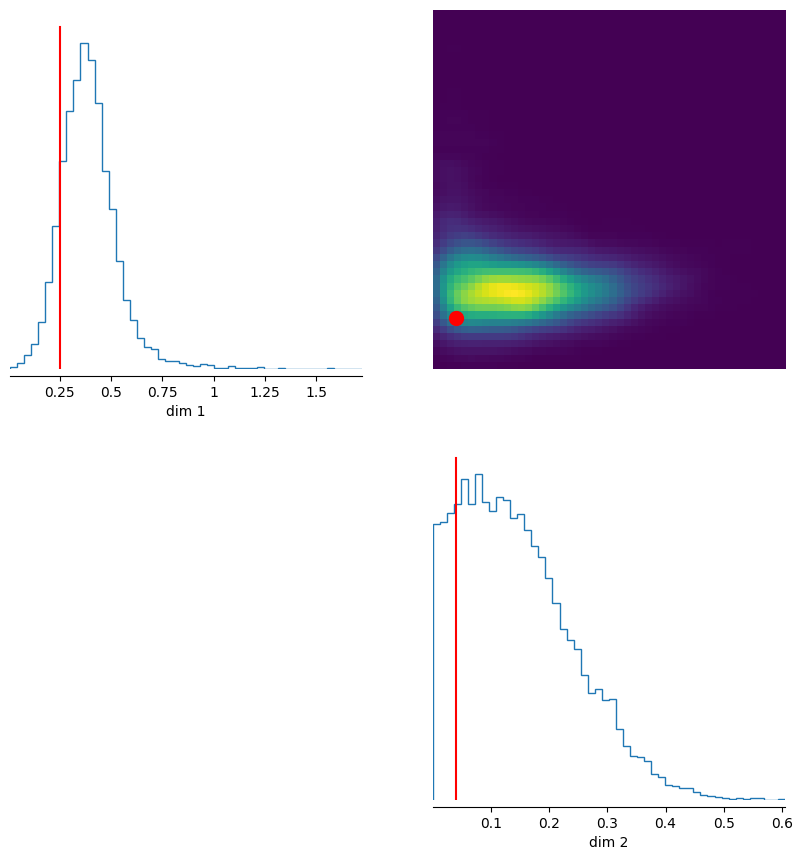

In [5]:
samples = posterior.sample((10_000,), x=x_obs)
_ = sbi.analysis.pairplot(
    samples=samples,
    points=theta_obs,
    points_colors="r",
    upper="kde",
)

## Example: Application of NLE on the SIR Dataset

We will use the same data as in the previous notebook, but now we will use the
neural likelihood estimator to construct the posterior.

**Task:** Use the provided the pseudo simulator to obtain the SIR dataset. Also,
standardized the data and split it into a training and test set.


In [21]:
# load the pre-simulated data from disk
data_theta, data_x = load_sir_data(c.data)

# initialize the scaler and the dataset
sir_scaler = SIRStdScaler()
dataset_z = sir_scaler({"theta": torch.tensor(data_theta[:-1]), "obs": torch.tensor(data_x[:-1])})
theta_z, x_z = dataset_z["theta"], dataset_z["obs"]

# remove the last pair from the dataset
obs_theta, obs_x = torch.tensor(data_theta[-1]).unsqueeze(0), torch.tensor(
    data_x[-1]
).unsqueeze(0)

data = sir_scaler({"theta": obs_theta, "obs": obs_x})
obs_theta_z, obs_x_z = data["theta"], data["obs"]

In [22]:
prior = torch.distributions.LogNormal(
    loc=torch.tensor([math.log(0.4), math.log(0.125)]),
    scale=torch.tensor([0.5, 0.2]),
)

In [23]:
# obtain a posterior approx. via NPE
# todo: the prior is not correct as labels have been scaled 
inference = sbi.inference.SNLE(prior=prior)
density_estimator = inference.append_simulations(theta_z, x_z).train()
posterior = inference.build_posterior(density_estimator)

 Training neural network. Epochs trained: 119

KeyboardInterrupt: 

## Neural Ratio Estimation 

one slide; all the info


## Practical Considerations for NPE vs. NLE and NRE

What do we have to keep in mind; when do we prefer which approach


## Summary 

summarize pros and cons for each method

| Method | Pros | Cons |
|:---|:---|:---|
|NPE |... |... |
|NLE |... |... |
|NRE |... |... |


## References

- sbi: A toolkit for simulation-based inference; [GitHub](https://www.mackelab.org/sbi/credits/)

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>